In [1]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



In [2]:

# Set definitions (should go to click)
m = 1
nsub = 3
nsim = 100
nmc = 1
npred = 10 #nsim


sigma = 0.0
zero = 'toy'



In [3]:
time_start = datetime.datetime.now()


def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


# Set utilities
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero='toy')
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(system_name, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset.load(
    filename=dataset_path,
    store=store,
    simhook = noise
)

Loading existing store.
Store has 113 simulations.
Image has L = 40.


In [4]:
# Load network
print(f'Loading {mre_path}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmc, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading ../data/mre/mre_toy_m_1_nsub_3_nsim_100_sigma_0.0_nmc_1.pt!


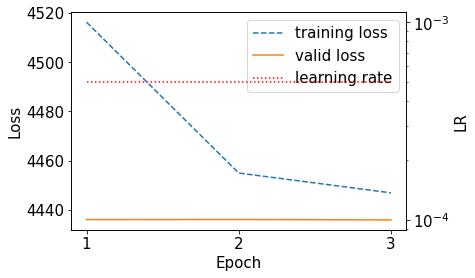

In [5]:
plot_losses(mre, save_name = get_ids(entry)[2])

In [6]:
def get_empty_and_full_coords(nmc, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full, m_centers, m_edges 

def get_obs(dataset, i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if i == -1 else i
    
    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coord_empty, coord_full, m_centers, m_edges = get_empty_and_full_coords(nmc, L)

mbins = np.linspace(lows[2], highs[2], nmc + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmc)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [7]:
prior = nsub/(L*L)/nmc
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmc) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.998125
pario halo 	0.001875


In [8]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(dataset, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()
    target = targets[nmc:].numpy()

    # Get logratios
    logratios = np.zeros((nmc*2, L, L))
    logratios[:nmc] = mre.network(obs0, coord_empty).view(nmc*2, L, L)[:nmc]
    logratios[nmc:] = mre.network(obs0, coord_full).view(nmc*2, L, L)[nmc:]
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmc, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    post = posts_norm[nmc:]
    
    obs0 = obs0['image'].squeeze().numpy()
    v0 = v0.numpy()
    
        
    return post, target, obs0, v0, obs0_i

post, target, obs0, v0, obs0_i = get_pred();
# post.shape, target.shape, obs0.shape, v0.shape

In [9]:
def get_target_coords(v0, target):
    x, y, m = v0.view(-1, 3).T.numpy()
    m_i = np.where(target == 1)[0]
    return np.array((m_i, y, x)).T


for _ in range(4):
    post, target, obs0, v0, obs0_i = get_pred()
    
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}} = 10^{ {m} }\ M_{{\odot}}$' for m in np.log10(m_centers.numpy())]

    log = True
#     plt_imshow(post, nrows, target_coords = get_target_coords(v0, target), cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)
#     plt_imshow(post, nrows, target_coords = target_coords_alt, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


In [10]:
pred = {
    'post':   np.zeros((npred, *post.shape)),
    'target': np.zeros((npred, *target.shape)),
    'obs0':   np.zeros((npred, *obs0.shape)),
    'v0':     np.zeros((npred, *v0.shape)),
    'obs0_i': np.zeros((npred)),
}

In [11]:
for i in tqdm(range(npred)): # loop over number of observations we will take into account
    post, target, obs0, v0, obs0_i = get_pred()
    for name, var in zip(pred.keys(), get_pred()):
        pred[name][i] = var
        
with open(pred_path, 'wb') as f:
    pickle.dump(pred, f)
    

100%|██████████| 10/10 [00:00<00:00, 28.46it/s]
